In [51]:
# %% [markdown]
# # 计算机视觉大作业 - 语义分割 (CamVid)
#
# 本 notebook 实现了在 CamVid 数据集上训练、测试语义分割模型，并可视化结果。

# %% [markdown]
# ## 1. 导入必要的库
#
# 在这个单元格中，我们导入所有需要的 Python 库。

# %%
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm # 用于显示进度条



In [52]:
# %% [markdown]
# ## 2. 配置参数和路径
#
# 设置模型训练和数据加载所需的参数，例如学习率、批大小、周期数以及数据路径。

# %%
import os
import random
import numpy as np
import pandas as pd
from PIL import Image
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm.notebook import tqdm # 用于显示进度条
import torch.nn.functional as F # 用于模型中的激活函数等


# ----- 数据集配置 -----
DATA_DIR = 'CamVid/' # CamVid 数据集根目录
CLASS_DICT_PATH = os.path.join(DATA_DIR, 'class_dict.csv')

# 预处理后的标签目录名称 (这些目录将在预处理步骤中创建)
TRAIN_LABELS_INDEXED_DIR = 'train_labels_indexed'
VAL_LABELS_INDEXED_DIR = 'val_labels_indexed'
TEST_LABELS_INDEXED_DIR = 'test_labels_indexed'

# ----- 模型选择和训练配置 -----
# 选择要使用的模型架构: 'UNet' 或 'SegNet'
MODEL_ARCH = 'SegNet' #'SegNet',UNet

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"将使用设备: {DEVICE}")

IMG_HEIGHT = 256 # 图像高度 (调整为你希望的大小)
IMG_WIDTH = 256  # 图像宽度 (调整为你希望的大小)

# BATCH_SIZE 需要根据你的 GPU 显存和选择的模型进行调整
# 不同的模型结构和参数会影响显存占用
# 对于 UNet(base_c=64, depth=4) 和 SegNet，BATCH_SIZE=16 或 32 是一个比较好的起点
BATCH_SIZE = 16
NUM_EPOCHS = 20  # 训练周期数
LEARNING_RATE = 2e-4 # 学习率
NUM_WORKERS = 4 # DataLoader 的工作线程数 (在标签预处理后，4-8通常足够)


# ----- 结果保存路径 -----
# 模型保存文件名可以包含模型架构名，方便区分
MODEL_SAVE_PATH = f'{MODEL_ARCH.lower()}_camvid_segmentation_model.pth'
TRAINING_CURVE_PATH = f'{MODEL_ARCH.lower()}_training_curves.png'
RESULTS_DIR = f'results_{MODEL_ARCH.lower()}/' # 测试结果可视化保存目录
if not os.path.exists(RESULTS_DIR):
    os.makedirs(RESULTS_DIR)

# ----- 随机种子 -----
SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

将使用设备: cuda


In [53]:
# %% [markdown]
# ## 2.1. 辅助函数和类别处理
#
# 定义一些辅助函数，例如加载类别信息、颜色映射等。

# %%
# 加载类别字典
class_df = pd.read_csv(CLASS_DICT_PATH)
CLASS_NAMES = class_df['name'].tolist()
# 将 r, g, b 列转换为元组列表 [(r,g,b), ...]
CLASS_COLORS = [tuple(row) for _, row in class_df[['r', 'g', 'b']].iterrows()]
NUM_CLASSES = len(CLASS_NAMES)

print(f"类别数量: {NUM_CLASSES}")
print(f"类别名称: {CLASS_NAMES}")
print(f"类别颜色 (部分): {CLASS_COLORS[:5]}")

# 创建颜色到类别索引的映射
color_to_idx = {color: i for i, color in enumerate(CLASS_COLORS)}
# 创建类别索引到颜色的映射
idx_to_color = {i: color for i, color in enumerate(CLASS_COLORS)}

def rgb_to_mask(rgb_img, color_to_idx_map):
    """
    将 RGB 掩码图像转换为类别索引掩码。
    此函数主要用于预处理或验证/调试原始标签。
    :param rgb_img: PIL Image 对象 (RGB)
    :param color_to_idx_map: 颜色到索引的映射字典
    :return: numpy array, 形状为 (H, W)，值为类别索引
    """
    rgb_img_np = np.array(rgb_img) # (H, W, 3)
    mask = np.zeros((rgb_img_np.shape[0], rgb_img_np.shape[1]), dtype=np.int64)
    # 注意: 遍历颜色并匹配比直接查找更慢，故用于预处理是合适的
    # 在训练循环中动态转换会成为瓶颈
    for color, idx in color_to_idx_map.items():
        # 查找与当前颜色完全匹配的像素位置
        # np.all(..., axis=2) 在 RGB 维度上检查是否所有颜色分量都匹配
        matches = np.all(rgb_img_np == np.array(color).reshape(1, 1, 3), axis=2)
        mask[matches] = idx
    return mask

def mask_to_rgb(mask_tensor, idx_to_color_map):
    """
    将类别索引掩码张量转换回 RGB PIL Image。
    :param mask_tensor: PyTorch 张量或 NumPy 数组, 形状为 (H, W) 或 (1, H, W), 值为类别索引
    :param idx_to_color_map: 索引到颜色的映射字典
    :return: PIL Image 对象 (RGB)
    """
    if isinstance(mask_tensor, torch.Tensor):
        if mask_tensor.ndim == 3:
            mask_tensor = mask_tensor.squeeze(0) # (H,W)
        mask_np = mask_tensor.cpu().numpy().astype(np.uint8)
    elif isinstance(mask_tensor, np.ndarray):
         mask_np = mask_tensor.astype(np.uint8)
    else:
        raise TypeError("mask_to_rgb 期望输入 PyTorch 张量或 NumPy 数组")

    rgb_mask = np.zeros((mask_np.shape[0], mask_np.shape[1], 3), dtype=np.uint8)
    for idx, color in idx_to_color_map.items():
        # 将掩码中值为 idx 的位置设置为对应的 RGB 颜色
        rgb_mask[mask_np == idx] = color
    return Image.fromarray(rgb_mask)

类别数量: 32
类别名称: ['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole', 'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock', 'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone', 'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall']
类别颜色 (部分): [(64, 128, 64), (192, 0, 128), (0, 128, 192), (0, 128, 64), (128, 0, 0)]


In [54]:
# %% [markdown]
# ## 2.5. 预处理标签 (将 RGB 标签转换为索引掩码)
#
# 这个单元格将原始的 RGB 标签图像转换为单通道的索引掩码图像。
# **注意：这个单元格只需要运行一次来生成预处理后的标签。**
# 它会检查目标文件是否已存在，如果存在则跳过，除非强制重新处理。

# %%
# ----- 标签预处理配置 -----
# 设置为 True 以运行预处理。如果大部分或所有文件已处理，它会自动跳过已存在的。
PREPROCESS_LABELS = True
# 如果你确定所有文件都已正确处理，可以将 PREPROCESS_LABELS 设置为 False 以完全跳过此单元格的逻辑。
# PREPROCESS_LABELS = False

# 新增：是否强制重新处理所有标签，即使它们已经存在
FORCE_REPROCESS = False # 如果设置为 True，即使目标文件已存在，也会重新处理

if PREPROCESS_LABELS:
    print("开始标签预处理检查...")
    # 确保 CLASS_DICT_PATH, class_df, CLASS_COLORS, color_to_idx, DATA_DIR 已经定义
    # (这些通常在 "3. 辅助函数和类别处理" 和 "2. 配置参数" 单元格中定义)
    if 'CLASS_COLORS' not in globals() or 'color_to_idx' not in globals() or 'DATA_DIR' not in globals():
        print("错误: 必要的全局变量 (如 CLASS_COLORS, color_to_idx, DATA_DIR) 未定义。")
        print("请确保已运行定义这些变量的单元格 (通常是单元格2和单元格3)。")
    else:
        # 使用之前定义的 rgb_to_mask 函数，只是可能需要确保其输入输出类型符合预处理需求
        # 确保 rgb_to_mask 函数在此作用域内可用，或者直接复制一份逻辑
        # 这里我们直接复制一份逻辑，确保它是基于PIL Image和numpy array操作
        def rgb_to_mask_for_preprocessing(rgb_img_pil, color_map):
            rgb_img_np = np.array(rgb_img_pil) # (H, W, 3)
            mask = np.zeros((rgb_img_np.shape[0], rgb_img_np.shape[1]), dtype=np.uint8) # CamVid有32类，uint8足够
            # 使用 np.where 可能会比循环稍微快一点，但循环也清晰易懂
            # indices = np.arange(len(color_map)) # [0, 1, 2, ...]
            # colors = np.array(list(color_map.keys())).reshape(1, 1, -1, 3) # (1, 1, N_classes, 3)
            # boolean_mask = np.all(rgb_img_np[:, :, None, :] == colors, axis=-1) # (H, W, N_classes)
            # mask = np.argmax(boolean_mask, axis=-1) # Assuming no overlaps and all pixels match a color
            # For robustness and explicit handling of colors, the loop is fine too:
            for color, idx in color_map.items():
                matches = np.all(rgb_img_np == np.array(color).reshape(1, 1, 3), axis=2)
                mask[matches] = idx
            return mask


        splits_to_process = {
            'train': ('train_labels', 'train_labels_indexed'),
            'val': ('val_labels', 'val_labels_indexed'),
            'test': ('test_labels', 'test_labels_indexed')
        }

        all_files_processed_count = 0
        all_files_skipped_count = 0
        any_errors = False

        for split_name, (original_subdir, indexed_subdir) in splits_to_process.items():
            original_label_dir = os.path.join(DATA_DIR, original_subdir)
            indexed_label_dir = os.path.join(DATA_DIR, indexed_subdir)
            os.makedirs(indexed_label_dir, exist_ok=True)

            if not os.path.exists(original_label_dir):
                print(f"警告: 原始标签目录 '{original_label_dir}' 不存在，跳过 '{split_name}' 的预处理。")
                continue

            print(f"检查并处理 '{original_label_dir}' 中的标签，保存到 '{indexed_label_dir}'...")
            # 假设标签文件是 PNG 格式
            filenames = [f for f in os.listdir(original_label_dir) if f.endswith('.png')] 
            
            processed_count = 0
            skipped_count = 0

            file_iterator = tqdm(filenames, desc=f"预处理 {split_name} 标签", unit="file")
            for filename in file_iterator:
                rgb_label_path = os.path.join(original_label_dir, filename)
                indexed_mask_path = os.path.join(indexed_label_dir, filename)

                if not FORCE_REPROCESS and os.path.exists(indexed_mask_path):
                    skipped_count += 1
                    continue # 跳到下一个文件

                try:
                    rgb_label_pil = Image.open(rgb_label_path).convert("RGB")
                    # 使用在当前单元格定义的预处理函数
                    indexed_mask_np = rgb_to_mask_for_preprocessing(rgb_label_pil, color_to_idx)
                    indexed_mask_pil = Image.fromarray(indexed_mask_np, mode='L') # 模式 'L' 表示 8 位像素，灰度图
                    indexed_mask_pil.save(indexed_mask_path)
                    processed_count += 1
                except Exception as e:
                    print(f"\n处理文件 {filename} 时出错: {e}")
                    any_errors = True
            
            all_files_processed_count += processed_count
            all_files_skipped_count += skipped_count
            print(f"'{split_name}' 标签处理完成: {processed_count} 个文件被处理, {skipped_count} 个文件已存在被跳过。")

        print("-" * 30)
        if any_errors:
            print("标签预处理期间发生错误。请检查上面的输出。")
        elif all_files_processed_count == 0 and all_files_skipped_count > 0 and not FORCE_REPROCESS:
            print(f"所有标签似乎都已预处理过。总共跳过了 {all_files_skipped_count} 个已存在的文件。")
        elif FORCE_REPROCESS:
             print(f"标签强制重新处理完成！总共处理了 {all_files_processed_count} 个文件。")
        else:
            print("标签预处理完成！")
            print(f"总共处理了 {all_files_processed_count} 个新文件。")
            print(f"总共跳过了 {all_files_skipped_count} 个已存在的文件。")
        print("-" * 30)

else:
    print("跳过标签预处理 (PREPROCESS_LABELS 设置为 False)。")
    # 仍然可以检查目录是否存在，以防后续代码依赖它们
    print("检查预处理目录是否存在...")
    all_indexed_dirs_exist = True
    splits_to_check = {
        'train': ('train_labels_indexed',),
        'val': ('val_labels_indexed',),
        'test': ('test_labels_indexed',)
    }
    for split_name, (indexed_subdir,) in splits_to_check.items():
        indexed_label_dir_check = os.path.join(DATA_DIR, indexed_subdir)
        if not os.path.exists(indexed_label_dir_check):
            print(f"警告: 预处理标签目录 '{indexed_label_dir_check}' ('{split_name}') 不存在。")
            all_indexed_dirs_exist = False
    if all_indexed_dirs_exist:
        print("所有预期的预处理标签目录均存在。")
    else:
        print("部分预处理标签目录缺失。如果这是首次运行或数据不完整，请考虑将 PREPROCESS_LABELS 设置为 True。")

开始标签预处理检查...
检查并处理 'CamVid/train_labels' 中的标签，保存到 'CamVid/train_labels_indexed'...


预处理 train 标签:   0%|          | 0/369 [00:00<?, ?file/s]

'train' 标签处理完成: 0 个文件被处理, 369 个文件已存在被跳过。
检查并处理 'CamVid/val_labels' 中的标签，保存到 'CamVid/val_labels_indexed'...


预处理 val 标签:   0%|          | 0/100 [00:00<?, ?file/s]

'val' 标签处理完成: 0 个文件被处理, 100 个文件已存在被跳过。
检查并处理 'CamVid/test_labels' 中的标签，保存到 'CamVid/test_labels_indexed'...


预处理 test 标签:   0%|          | 0/232 [00:00<?, ?file/s]

'test' 标签处理完成: 0 个文件被处理, 232 个文件已存在被跳过。
------------------------------
所有标签似乎都已预处理过。总共跳过了 701 个已存在的文件。
------------------------------


In [55]:
# %% [markdown]
# ## 4. 自定义数据集类 (CamVidDataset)
#
# 定义一个 PyTorch Dataset 类来加载 CamVid 数据。
# 这个版本假定标签已经被预处理为单通道索引掩码。

# %%
class CamVidDataset(Dataset):
    def __init__(self, image_dir, indexed_label_dir, transform=None, target_transform=None):
        """
        Args:
            image_dir (string): 包含图像的目录路径。
            indexed_label_dir (string): 包含预处理后的单通道索引掩码的目录路径。
            transform (callable, optional): 应用于样本图像的可选转换。
            target_transform (dict, optional): 应用于目标掩码的可选转换。
                                              应包含 'resize' 键，使用 NEAREST 插值。
        """
        self.image_dir = image_dir
        self.indexed_label_dir = indexed_label_dir # 使用预处理标签目录
        self.transform = transform
        self.target_transform = target_transform

        all_image_files = sorted([f for f in os.listdir(image_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])
        # 假设预处理后的标签文件名与原始标签文件名（例如 imagename_L.png）相同
        all_indexed_label_files = sorted([f for f in os.listdir(indexed_label_dir) if f.endswith(('.png', '.jpg', '.jpeg'))])

        self.image_filenames = []
        self.label_filenames = [] # 将存储匹配的预处理标签文件名

        set_all_indexed_label_files = set(all_indexed_label_files)

        print(f"从 '{image_dir}' 扫描到 {len(all_image_files)} 个图像文件。")
        print(f"从 '{indexed_label_dir}' 扫描到 {len(all_indexed_label_files)} 个预处理标签文件。")

        for img_fn in all_image_files:
            base_name, img_ext = os.path.splitext(img_fn)
            # 尝试匹配对应的标签文件名
            # CamVid 标签通常是 image_name_L.png
            expected_label_fn = f"{base_name}_L.png" 
            
            if expected_label_fn in set_all_indexed_label_files:
                self.image_filenames.append(img_fn)
                self.label_filenames.append(expected_label_fn)
            # else:
                # 可选：如果需要调试，可以取消注释打印哪些图像找不到对应标签
                # print(f"警告: 图像 '{img_fn}' 在 '{indexed_label_dir}' 中找不到对应的预处理标签 '{expected_label_fn}'。")


        print(f"成功匹配 {len(self.image_filenames)} 对图像和预处理标签。")

        assert len(self.image_filenames) == len(self.label_filenames), \
            "匹配后的图像和标签数量不一致，请检查文件名或匹配逻辑。"
        assert len(self.image_filenames) > 0, \
            f"在 '{image_dir}' 和 '{indexed_label_dir}' 之间未找到任何匹配的图像/标签对。请检查路径和文件名格式（预处理后的标签应为原始图像名加上 '_L.png' 后缀）。"


    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.indexed_label_dir, self.label_filenames[idx]) # 加载预处理的索引掩码

        image = Image.open(img_path).convert("RGB")
        
        # 加载预处理的索引掩码。它应该是单通道的 (PIL 模式 'L' 或 'I')
        label_mask_pil = Image.open(label_path) # 这已经是索引掩码了 (PIL Image)

        if self.transform:
            image = self.transform(image)

        # 对标签应用转换 (主要是 Resize)
        if self.target_transform:
            # Resize (使用最近邻插值)
            if 'resize' in self.target_transform:
                 label_mask_pil = self.target_transform['resize'](label_mask_pil)
            
            # PIL Image to numpy array (确保是整数类型)
            label_mask_np = np.array(label_mask_pil, dtype=np.uint8) # 确保类型正确
            
            # Numpy array to PyTorch LongTensor
            label_mask = torch.from_numpy(label_mask_np).long() # (H, W)
        else:
            # 如果没有指定 target_transform，确保至少转换为 LongTensor
            label_mask_np = np.array(label_mask_pil, dtype=np.uint8)
            label_mask = torch.from_numpy(label_mask_np).long()


        return image, label_mask

In [56]:
# %% [markdown]
# ## 5. 数据预处理和 DataLoader
#
# 定义图像和标签的转换，并创建 DataLoader。

# %%
# 定义图像的转换 (保持不变)
image_transforms = transforms.Compose([
    transforms.Resize((IMG_HEIGHT, IMG_WIDTH)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]) # ImageNet 均值和标准差
])

# 定义标签的转换
# 现在标签是预处理的索引掩码 (PIL Image, mode 'L')
# 我们只需要 Resize (用最近邻)
# 转换到 Tensor 的步骤将在 Dataset 的 __getitem__ 中直接处理 (np.array -> torch.from_numpy().long())
label_target_transforms = {
    'resize': transforms.Resize((IMG_HEIGHT, IMG_WIDTH), interpolation=transforms.InterpolationMode.NEAREST),
    # 'to_tensor' 不再需要这里，因为我们在 Dataset 内部直接转为 LongTensor
}


# 创建数据集实例 (使用预处理后的标签目录)
train_dataset = CamVidDataset(
    image_dir=os.path.join(DATA_DIR, 'train'),
    indexed_label_dir=os.path.join(DATA_DIR, TRAIN_LABELS_INDEXED_DIR), # 使用新的目录
    transform=image_transforms,
    target_transform=label_target_transforms
)

val_dataset = CamVidDataset(
    image_dir=os.path.join(DATA_DIR, 'val'),
    indexed_label_dir=os.path.join(DATA_DIR, VAL_LABELS_INDEXED_DIR), # 使用新的目录
    transform=image_transforms,
    target_transform=label_target_transforms
)

test_dataset = CamVidDataset(
    image_dir=os.path.join(DATA_DIR, 'test'),
    indexed_label_dir=os.path.join(DATA_DIR, TEST_LABELS_INDEXED_DIR), # 使用新的目录
    transform=image_transforms,
    target_transform=label_target_transforms
)

# 创建 DataLoader
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS, pin_memory=True)

print(f"训练集大小: {len(train_dataset)}")
print(f"验证集大小: {len(val_dataset)}")
print(f"测试集大小: {len(test_dataset)}")

# (可选) 检查 DataLoader 是否能成功获取数据
if len(train_dataset) > 0:
    try:
        img_batch, mask_batch = next(iter(train_loader))
        print(f"成功从 train_loader 获取一批数据: images shape {img_batch.shape}, masks shape {mask_batch.shape}, masks dtype {mask_batch.dtype}")
        assert mask_batch.dtype == torch.long, f"Masks dtype is {mask_batch.dtype}, should be torch.long"
    except Exception as e:
        print(f"从 DataLoader 获取数据时出错: {e}")
        print("请检查 CamVidDataset 的 __getitem__ 实现以及标签预处理是否正确。")

从 'CamVid/train' 扫描到 369 个图像文件。
从 'CamVid/train_labels_indexed' 扫描到 369 个预处理标签文件。
成功匹配 369 对图像和预处理标签。
从 'CamVid/val' 扫描到 100 个图像文件。
从 'CamVid/val_labels_indexed' 扫描到 100 个预处理标签文件。
成功匹配 100 对图像和预处理标签。
从 'CamVid/test' 扫描到 232 个图像文件。
从 'CamVid/test_labels_indexed' 扫描到 232 个预处理标签文件。
成功匹配 232 对图像和预处理标签。
训练集大小: 369
验证集大小: 100
测试集大小: 232


/home/u220110828/HITSZ-CV-2025/CV_Project/.conda/lib/python3.11/site-packages/torch/utils/data/dataloader.py:626: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


成功从 train_loader 获取一批数据: images shape torch.Size([16, 3, 256, 256]), masks shape torch.Size([16, 256, 256]), masks dtype torch.int64


显示训练集中的一个样本:


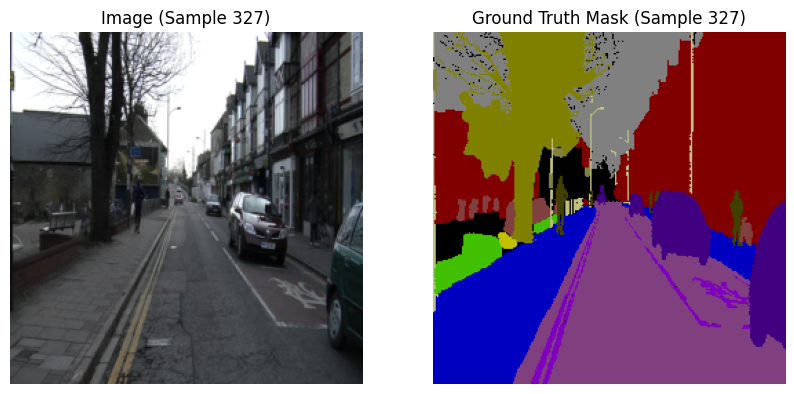

In [57]:
# %% [markdown]
# ### 5.1 可视化一个样本 (可选)
# 检查数据加载和预处理是否正确。

# %%
def show_sample(dataset, index=None):
    if index is None:
        index = random.randint(0, len(dataset) - 1)
    
    img, mask = dataset[index] # img is (C,H,W) tensor, mask is (H,W) tensor

    # 反归一化图像以便显示
    inv_normalize = transforms.Normalize(
        mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
        std=[1/0.229, 1/0.224, 1/0.225]
    )
    img_display = inv_normalize(img)
    img_display = transforms.ToPILImage()(img_display)

    # 将掩码转换为 RGB 以便显示
    mask_rgb_display = mask_to_rgb(mask, idx_to_color)

    fig, ax = plt.subplots(1, 2, figsize=(10, 5))
    ax[0].imshow(img_display)
    ax[0].set_title(f"Image (Sample {index})")
    ax[0].axis('off')

    ax[1].imshow(mask_rgb_display)
    ax[1].set_title(f"Ground Truth Mask (Sample {index})")
    ax[1].axis('off')
    plt.show()

# 从训练集中显示一个样本
print("显示训练集中的一个样本:")
show_sample(train_dataset)



In [ ]:
# %% [markdown]
# ## 6. 定义模型 (SimpleUNet 和 SegNet)
#
# 定义 SimpleUNet (基础版 U-Net) 和 SegNet 模型结构，并根据配置选择实例化哪个模型。

# %%
import torch
import torch.nn as nn
import torch.nn.functional as F # 用于模型中的激活函数等

# ----- SimpleUNet 模型定义 (你最初的版本) -----
class DoubleConv(nn.Module): # 这个 DoubleConv 同时被 SimpleUNet 和我们后来改进的 UNet 使用
    """(convolution => [BN] => ReLU) * 2"""
    def __init__(self, in_channels, out_channels, mid_channels=None, dropout_rate=0.0): # dropout_rate 为兼容性，在SimpleUNet中不使用
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        
        # SimpleUNet 的 DoubleConv 不包含 dropout
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )
    def forward(self, x):
        return self.double_conv(x)

class Down(nn.Module): # 这个 Down 同时被 SimpleUNet 和我们后来改进的 UNet 使用
    """Downscaling with maxpool then double conv"""
    def __init__(self, in_channels, out_channels, dropout_rate=0.0): # dropout_rate 为兼容性
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels) # SimpleUNet 的 Down 不传递 dropout
        )
    def forward(self, x):
        return self.maxpool_conv(x)

class Up(nn.Module): # 这个 Up 同时被 SimpleUNet 和我们后来改进的 UNet 使用
    """Upscaling then double conv"""
    def __init__(self, in_channels_x1, in_channels_x2, out_channels_block, bilinear=True, dropout_rate=0.0): # dropout_rate 为兼容性
        # 注意：SimpleUNet 调用 Up 时，参数映射可能略有不同。
        # SimpleUNet(in_channels, out_channels, bilinear=True) -> in_channels是DoubleConv的输入，out_channels是DoubleConv的输出
        # 这里的 in_channels_x1 指的是来自解码器上一层（或瓶颈层）的通道数 (将被上采样)
        # in_channels_x2 指的是来自编码器跳跃连接的通道数
        # out_channels_block 指的是此 Up 块最终输出的通道数
        super().__init__()
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # 对于 SimpleUNet:
            # up1: Up(1024, 512 // factor, bilinear)
            # 这里的 1024 是 x1 的通道数， 512//factor 是跳跃连接的通道数吗？ 不，这是 SimpleUNet Up 的简化参数
            # SimpleUNet Up(in_channels, out_channels, bilinear)
            # in_channels 指的是 upsample/convtranspose 之后的通道数 + skip connection 的通道数 (提供给 DoubleConv)
            # out_channels 指的是 DoubleConv 的输出通道数
            # 所以 SimpleUNet 的 Up(1024, 512//factor) 意味着 DoubleConv 的输入是 1024，输出是 512//factor
            # 那么 self.up 需要的输入通道数是 1024 - (skip_connection_channels)
            # 我们需要根据 SimpleUNet 的 `Up` 调用方式来调整这里的 `DoubleConv` 的输入通道
            # SimpleUNet: self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            #             self.conv = DoubleConv(in_channels, out_channels)
            # 这意味着，如果 bilinear=False, DoubleConv 的输入是 (in_channels//2 from up) + (in_channels//2 from skip) = in_channels
            # 如果 bilinear=True,   DoubleConv 的输入是 (in_channels from up) + (skip_channels)
            # 为了保持 SimpleUNet 的原始行为，我们需要让这个 Up 模块能像它那样工作
            # SimpleUNet 的 Up(A, B) 中，A 是进入 DoubleConv 的总通道数，B 是 DoubleConv 输出的通道数
            # 如果 bilinear=True:
            #    self.up = nn.Upsample(...)
            #    self.conv = DoubleConv(A, B, A // 2) # A是 x1_upsampled + x2_skip, B 是输出
            # 如果 bilinear=False:
            #    self.up = nn.ConvTranspose2d(A_x1, A_x1 // 2, ...)
            #    self.conv = DoubleConv(A_x1 // 2 + A_x2, B) -> A_x1//2+A_x2 应该等于 A
            
            # 让我们直接使用 SimpleUNet 的 Up 定义参数方式
            # Up(in_channels_for_double_conv, out_channels_for_double_conv, bilinear)
            # in_channels_for_double_conv = channels_from_upsample + channels_from_skip
            # mid_channels_for_double_conv = in_channels_for_double_conv // 2 (for bilinear in SimpleUNet)

            # 这里的参数 in_channels_skip, in_channels_up, out_channels_block 来自更通用的UNet
            # 我们需要让 SimpleUNet 的 Up 也能用这些通用组件，或者为 SimpleUNet 单独写一个 Up
            # 为了简单，我们直接用 SimpleUNet 的 Up 构造方式，它接受 `in_channels` (用于DoubleConv的输入)
            # 和 `out_channels` (用于DoubleConv的输出)
            # 这个 `in_channels` 是拼接后的通道数。
            # self.up 的输入通道需要从这里推断
            
            # 让 Up 的参数更像 SimpleUNet 的原始设计
            # Up(in_c_after_concat, out_c_final, bilinear=True)
            # where in_c_after_concat is the number of channels for DoubleConv's input
            # and out_c_final is the number of channels for DoubleConv's output
            # The 'in_channels_skip' and 'in_channels_up' are not directly used to construct Up in SimpleUNet
            # Instead, SimpleUNet's Up takes (total_input_to_conv, output_from_conv)
            
            # 为了保持 SimpleUNet 的简洁性，我们将恢复其原始的 Up 模块
            # 这个通用的 Up 模块对于 SimpleUNet 来说参数传递有点复杂
            # 因此，我们将为 SimpleUNet 保留其自己的 Up 定义
            pass # 下面会定义 SimpleUNet 专用的 Up

        else: # bilinear=False
            # self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            # self.conv = DoubleConv(in_channels, out_channels)
            pass


class OutConv(nn.Module): # 这个 OutConv 同时被 SimpleUNet 和我们后来改进的 UNet 使用
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)
    def forward(self, x):
        return self.conv(x)

# 为 SimpleUNet 定义其特有的 Up 模块
class SimpleUNetUp(nn.Module):
    """Upscaling then double conv (SimpleUNet specific)"""
    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()
        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            # DoubleConv(in_total_after_concat, out_final, mid_for_double_conv)
            # in_channels here is total for DoubleConv, mid is in_channels // 2 for SimpleUNet
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            # in_channels is the number of channels of x1 (the one to be upsampled by ConvTranspose)
            # out_channels is the final output channels of this Up block
            # ConvTranspose will output in_channels // 2
            # DoubleConv will take (in_channels // 2 from up) + (in_channels // 2 from skip) = in_channels (as input)
            # and output out_channels
            self.up = nn.ConvTranspose2d(in_channels_x1 = in_channels, # x1 is the input to ConvTranspose
                                         out_channels_x1_up = in_channels // 2, # output of ConvTranspose
                                         kernel_size=2, stride=2)
            # DoubleConv input is (output of ConvTranspose) + (channels of skip connection)
            # In SimpleUNet, if bilinear=False, skip connection has in_channels//2.
            # So DoubleConv input becomes (in_channels//2) + (in_channels//2) = in_channels.
            self.conv = DoubleConv(in_channels, out_channels)


    def forward(self, x1, x2): # x1 from upsample, x2 from skip connection
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        factor = 2 if bilinear else 1 # This factor logic was for channel division, needs careful check

        self.inc = DoubleConv(n_channels, 64)
        self.down1 = Down(64, 128)
        self.down2 = Down(128, 256)
        self.down3 = Down(256, 512)
        # Bottleneck layer, channels depend on bilinear for the first Up block
        # If bilinear=True, up1's DoubleConv takes 1024 (512 from upsample, 512 from skip)
        # If bilinear=False, up1's ConvTranspose takes 1024, outputs 512. Skip is 512. DoubleConv takes 1024.
        # So, the output of down4 should be 1024 if bilinear=False for up1, or 512 if bilinear=True for up1.
        # Let's follow the original SimpleUNet structure where bilinear affects the channels for DoubleConv *inside* Up
        # The output of the last Down block is `1024 // factor` in the original simple_unet.py
        # This means if bilinear, bottleneck is 512. If not, bottleneck is 1024.
        self.down4 = Down(512, 1024 // factor)

        # The `in_channels` for SimpleUNetUp should be:
        # - For bilinear=True: (channels of x1_upsampled) + (channels of x2_skip)
        # - For bilinear=False: (channels of x1 fed to ConvTranspose)
        # The `out_channels` for SimpleUNetUp is the final output of its DoubleConv.

        # Let's use the original SimpleUNet structure's channel numbers for Up blocks:
        # Up(in_channels_for_double_conv, out_channels_for_double_conv, bilinear)
        # if bilinear=True: up1: Up(1024, 512, True)  -> upsamples 512 (from down4) to 512. Skip is 512 (from down3). Cat is 1024. Output is 512.
        # if bilinear=False: up1: Up(1024, 256, False) -> ConvTranspose takes 1024 (from down4), outputs 512. Skip is 512 (from down3). Cat is 1024. Output is 256.
        # This `factor` logic is confusing. Let's use the channel definitions from a known working SimpleUNet.

        # A common Simple U-Net structure:
        # inc: 3 -> 64
        # down1: 64 -> 128
        # down2: 128 -> 256
        # down3: 256 -> 512
        # down4: 512 -> 1024 (bottleneck features to be passed to first upsample)
        #
        # up1: takes 1024 (from down4), skip 512 (from down3). Outputs 512.
        #      If bilinear, upsample(1024) -> 1024. Cat(1024, 512) -> 1536. Conv(1536, 512).
        #      If ConvTranspose, ConvTranspose(1024) -> 512. Cat(512, 512) -> 1024. Conv(1024, 512).
        # This is the standard U-Net way. The `factor` was for a specific implementation.

        # Reverting to a more standard U-Net channel progression for SimpleUNet:
        self.down4 = Down(512, 1024) # Bottleneck is 1024 channels

        # Up(in_channels_x1, in_channels_x2_skip, out_channels_final, bilinear)
        # For the ConvTranspose version (bilinear=False):
        # x1 is input to ConvTranspose, x2 is skip.
        # ConvTranspose(in_x1) -> out_x1_up. Cat(out_x1_up, in_x2_skip). DoubleConv -> out_final
        # In original SimpleUNet, the `in_channels` for `Up` was the input to ConvTranspose if `bilinear=False`.
        # And `out_channels` was the final output.
        # Let's use a custom Up for SimpleUNet that takes (in_channels_for_ConvT_or_input_to_Upsample, out_channels_final)

        # Define SimpleUNet's Up block again, with clearer parameter names for its specific usage
        class _SimpleUNetUp(nn.Module):
            def __init__(self, in_ch_x1, skip_ch_x2, out_ch_final, bilinear_upsample):
                super().__init__()
                if bilinear_upsample:
                    self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
                    # After upsampling in_ch_x1, it's still in_ch_x1 channels.
                    # Concatenated with skip_ch_x2.
                    # DoubleConv input: in_ch_x1 + skip_ch_x2. Output: out_ch_final.
                    # Mid channels for DoubleConv in SimpleUNet's bilinear case is (in_ch_x1 + skip_ch_x2) // 2
                    self.conv = DoubleConv(in_ch_x1 + skip_ch_x2, out_ch_final, (in_ch_x1 + skip_ch_x2) // 2)
                else:
                    # ConvTranspose takes in_ch_x1, outputs in_ch_x1 // 2 (standard U-Net way)
                    self.up = nn.ConvTranspose2d(in_ch_x1, in_ch_x1 // 2, kernel_size=2, stride=2)
                    # DoubleConv input: (in_ch_x1 // 2) + skip_ch_x2. Output: out_ch_final.
                    self.conv = DoubleConv((in_ch_x1 // 2) + skip_ch_x2, out_ch_final)

            def forward(self, x1, x2): # x1 from previous decoder layer (or bottleneck), x2 from encoder skip
                x1 = self.up(x1)
                diffY = x2.size()[2] - x1.size()[2]
                diffX = x2.size()[3] - x1.size()[3]
                x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                                diffY // 2, diffY - diffY // 2])
                x = torch.cat([x2, x1], dim=1)
                return self.conv(x)

        self.up1 = _SimpleUNetUp(1024, 512, 512, bilinear) # Takes 1024 from bottleneck, 512 skip, outputs 512
        self.up2 = _SimpleUNetUp(512, 256, 256, bilinear)  # Takes 512, 256 skip, outputs 256
        self.up3 = _SimpleUNetUp(256, 128, 128, bilinear)  # Takes 256, 128 skip, outputs 128
        self.up4 = _SimpleUNetUp(128, 64, 64, bilinear)    # Takes 128, 64 skip, outputs 64
        self.outc = OutConv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4) # Bottleneck

        x = self.up1(x5, x4) # x5 is from bottleneck (1024), x4 is skip from enc (512)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        return logits


# ----- SegNet 模型定义 (保持不变) -----
class SegNet(nn.Module):
    def __init__(self, in_chn=3, out_chn=32, BN_momentum=0.1):
        super(SegNet, self).__init__()
        self.in_chn = in_chn
        self.out_chn = out_chn

        self.MaxEn = nn.MaxPool2d(2, stride=2, return_indices=True)
        self.ConvEn11 = nn.Conv2d(self.in_chn, 64, kernel_size=3, padding=1)
        self.BNEn11 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNEn12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvEn21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.BNEn21 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNEn22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvEn31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.BNEn31 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNEn33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvEn41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.BNEn41 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvEn53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNEn53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.MaxDe = nn.MaxUnpool2d(2, stride=2)
        self.ConvDe53 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe53 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe52 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe52 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe51 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe51 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe43 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe43 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.BNDe42 = nn.BatchNorm2d(512, momentum=BN_momentum)
        self.ConvDe41 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.BNDe41 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe33 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe33 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.BNDe32 = nn.BatchNorm2d(256, momentum=BN_momentum)
        self.ConvDe31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.BNDe31 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.BNDe22 = nn.BatchNorm2d(128, momentum=BN_momentum)
        self.ConvDe21 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.BNDe21 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.BNDe12 = nn.BatchNorm2d(64, momentum=BN_momentum)
        self.ConvDe11 = nn.Conv2d(64, self.out_chn, kernel_size=3, padding=1)

    def forward(self, x):
        x = F.relu(self.BNEn11(self.ConvEn11(x)))
        x = F.relu(self.BNEn12(self.ConvEn12(x)))
        size1 = x.size(); x, ind1 = self.MaxEn(x)
        x = F.relu(self.BNEn21(self.ConvEn21(x)))
        x = F.relu(self.BNEn22(self.ConvEn22(x)))
        size2 = x.size(); x, ind2 = self.MaxEn(x)
        x = F.relu(self.BNEn31(self.ConvEn31(x)))
        x = F.relu(self.BNEn32(self.ConvEn32(x)))
        x = F.relu(self.BNEn33(self.ConvEn33(x)))
        size3 = x.size(); x, ind3 = self.MaxEn(x)
        x = F.relu(self.BNEn41(self.ConvEn41(x)))
        x = F.relu(self.BNEn42(self.ConvEn42(x)))
        x = F.relu(self.BNEn43(self.ConvEn43(x)))
        size4 = x.size(); x, ind4 = self.MaxEn(x)
        x = F.relu(self.BNEn51(self.ConvEn51(x)))
        x = F.relu(self.BNEn52(self.ConvEn52(x)))
        x = F.relu(self.BNEn53(self.ConvEn53(x)))
        size5 = x.size(); x, ind5 = self.MaxEn(x)
        x = self.MaxDe(x, ind5, output_size=size5)
        x = F.relu(self.BNDe53(self.ConvDe53(x)))
        x = F.relu(self.BNDe52(self.ConvDe52(x)))
        x = F.relu(self.BNDe51(self.ConvDe51(x)))
        x = self.MaxDe(x, ind4, output_size=size4)
        x = F.relu(self.BNDe43(self.ConvDe43(x)))
        x = F.relu(self.BNDe42(self.ConvDe42(x)))
        x = F.relu(self.BNDe41(self.ConvDe41(x)))
        x = self.MaxDe(x, ind3, output_size=size3)
        x = F.relu(self.BNDe33(self.ConvDe33(x)))
        x = F.relu(self.BNDe32(self.ConvDe32(x)))
        x = F.relu(self.BNDe31(self.ConvDe31(x)))
        x = self.MaxDe(x, ind2, output_size=size2)
        x = F.relu(self.BNDe22(self.ConvDe22(x)))
        x = F.relu(self.BNDe21(self.ConvDe21(x)))
        x = self.MaxDe(x, ind1, output_size=size1)
        x = F.relu(self.BNDe12(self.ConvDe12(x)))
        x = self.ConvDe11(x)
        return x

# ----- 实例化模型 -----
# 确保 NUM_CLASSES 和 DEVICE 已经定义 (来自之前的单元格)
# 确保 MODEL_ARCH 已经定义 (来自单元格2 "配置参数和路径")

print(f"根据配置选择模型架构: {MODEL_ARCH}")

if MODEL_ARCH == 'UNet': 
    model = UNet(
        n_channels=3,
        n_classes=NUM_CLASSES, # 确保 NUM_CLASSES 已定义
        bilinear=True          # SimpleUNet 的 bilinear 参数
    ).to(DEVICE)
    print("SimpleUNet 模型已实例化。")

elif MODEL_ARCH == 'SegNet':
    model = SegNet(
        in_chn=3,
        out_chn=NUM_CLASSES, # 确保 NUM_CLASSES 已定义
        BN_momentum=0.1
    ).to(DEVICE)
    print("SegNet 模型已实例化。")

else:
    raise ValueError(f"未知的模型架构: {MODEL_ARCH}。请在配置单元格中将 MODEL_ARCH 设置为 'SimpleUNet' 或 'SegNet'。")

print(f"模型已加载到: {DEVICE}")
# print(model) # (可选) 打印模型结构

根据配置选择模型架构: SegNet
SegNet 模型已实例化。
模型已加载到: cuda


In [59]:
# %% [markdown]
# ## 7. 定义损失函数和优化器

# %%
# 损失函数 (交叉熵损失)
# 注意：CrossEntropyLoss 期望的 target 是 (N, H, W) 且为 long 类型，值为类别索引
# 而 input 是 (N, C, H, W) 的 logits
criterion = nn.CrossEntropyLoss()

# 优化器
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

# 学习率调度器
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=2)



In [60]:
# %% [markdown]
# ## 8. 训练模型
#
# 编写训练循环。

# %%
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    epoch_loss = 0.0
    
    progress_bar = tqdm(loader, desc="训练中", leave=False)
    for images, masks in progress_bar:
        images = images.to(device)
        masks = masks.to(device) # masks shape (batch_size, H, W), long type

        optimizer.zero_grad()
        outputs = model(images) # outputs shape (batch_size, num_classes, H, W)
        
        loss = criterion(outputs, masks)
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        progress_bar.set_postfix(loss=loss.item())
        
    return epoch_loss / len(loader)

def validate_one_epoch(model, loader, criterion, device):
    model.eval()
    epoch_loss = 0.0
    pixel_accuracy_sum = 0.0
    num_pixels_total = 0
    
    progress_bar = tqdm(loader, desc="验证中", leave=False)
    with torch.no_grad():
        for images, masks in progress_bar:
            images = images.to(device)
            masks = masks.to(device)

            outputs = model(images)
            loss = criterion(outputs, masks)
            epoch_loss += loss.item()

            # 计算像素准确率
            preds = torch.argmax(outputs, dim=1) # (batch_size, H, W)
            correct_pixels = (preds == masks).sum().item()
            total_pixels_in_batch = masks.nelement() # batch_size * H * W
            
            pixel_accuracy_sum += correct_pixels
            num_pixels_total += total_pixels_in_batch
            
            progress_bar.set_postfix(loss=loss.item(), acc=(correct_pixels/total_pixels_in_batch))

    avg_loss = epoch_loss / len(loader)
    avg_pixel_accuracy = pixel_accuracy_sum / num_pixels_total if num_pixels_total > 0 else 0
    return avg_loss, avg_pixel_accuracy

# 训练历史记录
history = {'train_loss': [], 'val_loss': [], 'val_accuracy': []}
best_val_loss = float('inf')

print("开始训练...")
for epoch in range(NUM_EPOCHS):
    train_loss = train_one_epoch(model, train_loader, criterion, optimizer, DEVICE)
    val_loss, val_accuracy = validate_one_epoch(model, val_loader, criterion, DEVICE)
    
    history['train_loss'].append(train_loss)
    history['val_loss'].append(val_loss)
    history['val_accuracy'].append(val_accuracy)

    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], "
          f"Train Loss: {train_loss:.4f}, "
          f"Val Loss: {val_loss:.4f}, "
          f"Val Pixel Acc: {val_accuracy:.4f}")

    # (可选) 更新学习率调度器
    # scheduler.step(val_loss)

    # 保存最佳模型
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"模型已保存到 {MODEL_SAVE_PATH} (Val Loss: {best_val_loss:.4f})")

print("训练完成!")



开始训练...


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [1/20], Train Loss: 2.4623, Val Loss: 2.6239, Val Pixel Acc: 0.2877
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 2.6239)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [2/20], Train Loss: 1.4449, Val Loss: 1.2871, Val Pixel Acc: 0.6369
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 1.2871)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [3/20], Train Loss: 1.1743, Val Loss: 1.1138, Val Pixel Acc: 0.6923
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 1.1138)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [4/20], Train Loss: 1.0279, Val Loss: 1.2406, Val Pixel Acc: 0.6599


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [5/20], Train Loss: 1.0665, Val Loss: 1.3347, Val Pixel Acc: 0.6146


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [6/20], Train Loss: 0.9706, Val Loss: 0.9462, Val Pixel Acc: 0.7444
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.9462)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [7/20], Train Loss: 0.8954, Val Loss: 0.8960, Val Pixel Acc: 0.7647
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.8960)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [8/20], Train Loss: 0.8389, Val Loss: 0.8725, Val Pixel Acc: 0.7745
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.8725)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [9/20], Train Loss: 0.8247, Val Loss: 0.8296, Val Pixel Acc: 0.7875
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.8296)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [10/20], Train Loss: 0.7709, Val Loss: 0.7891, Val Pixel Acc: 0.7925
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.7891)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [11/20], Train Loss: 0.7459, Val Loss: 0.7506, Val Pixel Acc: 0.7988
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.7506)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [12/20], Train Loss: 0.7306, Val Loss: 0.8706, Val Pixel Acc: 0.7527


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [13/20], Train Loss: 0.7257, Val Loss: 0.7561, Val Pixel Acc: 0.7937


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [14/20], Train Loss: 0.6950, Val Loss: 0.8781, Val Pixel Acc: 0.7685


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [15/20], Train Loss: 0.7024, Val Loss: 0.6985, Val Pixel Acc: 0.8083
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.6985)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [16/20], Train Loss: 0.6651, Val Loss: 0.7911, Val Pixel Acc: 0.7719


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [17/20], Train Loss: 0.6726, Val Loss: 0.8159, Val Pixel Acc: 0.7821


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [18/20], Train Loss: 0.6463, Val Loss: 0.6875, Val Pixel Acc: 0.8138
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.6875)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [19/20], Train Loss: 0.6034, Val Loss: 0.6246, Val Pixel Acc: 0.8321
模型已保存到 segnet_camvid_segmentation_model.pth (Val Loss: 0.6246)


训练中:   0%|          | 0/24 [00:00<?, ?it/s]

验证中:   0%|          | 0/7 [00:00<?, ?it/s]

Epoch [20/20], Train Loss: 0.6360, Val Loss: 0.7667, Val Pixel Acc: 0.7843
训练完成!


训练曲线图已保存到 segnet_training_curves.png


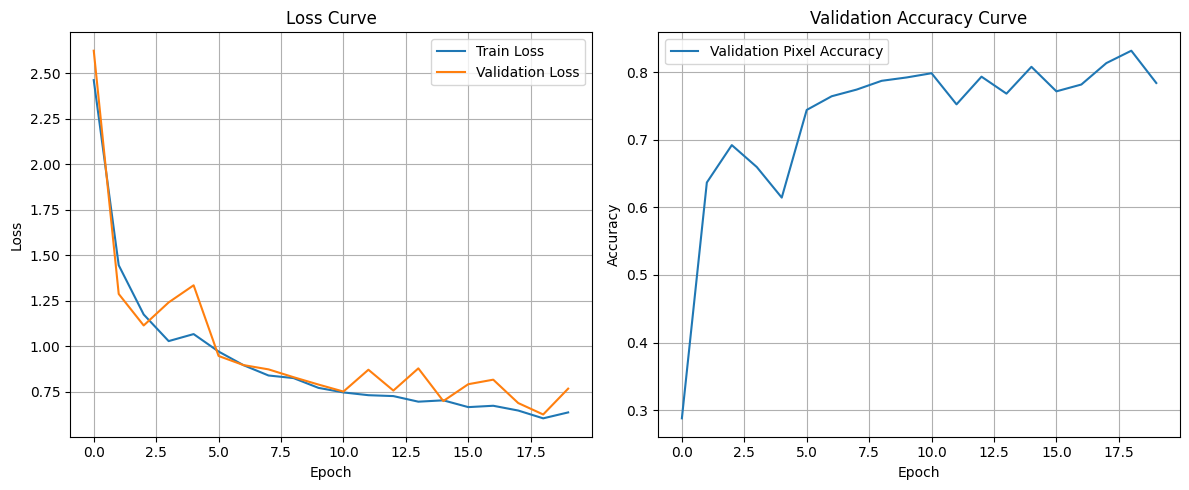

In [61]:
# %% [markdown]
# ## 9. 绘制训练曲线
#
# 可视化训练过程中的损失和准确率变化。

# %%
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['val_accuracy'], label='Validation Pixel Accuracy')
plt.title('Validation Accuracy Curve')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig(TRAINING_CURVE_PATH)
print(f"训练曲线图已保存到 {TRAINING_CURVE_PATH}")
plt.show()




In [62]:
# %% [markdown]
# ## 10. 在测试集上评估模型
#
# 加载最佳模型，并在测试集上进行评估。计算像素准确率和平均 IoU (mIoU)。
# 注意：mIoU 的计算会稍微复杂一些。

# %%
# 加载最佳模型权重
if os.path.exists(MODEL_SAVE_PATH):
    model.load_state_dict(torch.load(MODEL_SAVE_PATH, map_location=DEVICE))
    print(f"从 {MODEL_SAVE_PATH} 加载了模型权重。")
else:
    print(f"警告: 未找到模型权重 {MODEL_SAVE_PATH}，将使用当前模型状态进行评估。")

model.eval() # 设置为评估模式

test_loss_sum = 0.0
test_pixel_accuracy_sum = 0.0
test_num_pixels_total = 0

# --- mIoU 计算 ---
# intersection_meter = AverageMeter() # 需要自己实现或找一个 AverageMeter 类
# union_meter = AverageMeter() #
# target_meter = AverageMeter() #
# 或者直接用numpy数组累加
intersection_per_class = np.zeros(NUM_CLASSES)
union_per_class = np.zeros(NUM_CLASSES)
# ------------------

progress_bar = tqdm(test_loader, desc="测试中", leave=False)
with torch.no_grad():
    for images, masks in progress_bar:
        images = images.to(DEVICE)
        masks = masks.to(DEVICE) # (B, H, W)

        outputs = model(images) # (B, C, H, W)
        loss = criterion(outputs, masks)
        test_loss_sum += loss.item()

        preds = torch.argmax(outputs, dim=1) # (B, H, W)

        # 计算像素准确率
        correct_pixels = (preds == masks).sum().item()
        total_pixels_in_batch = masks.nelement()
        test_pixel_accuracy_sum += correct_pixels
        test_num_pixels_total += total_pixels_in_batch
        
        # --- mIoU 计算 ---
        preds_np = preds.cpu().numpy()
        masks_np = masks.cpu().numpy()

        for i in range(NUM_CLASSES):
            pred_i = (preds_np == i)
            mask_i = (masks_np == i)
            
            intersection = np.logical_and(pred_i, mask_i).sum()
            union = np.logical_or(pred_i, mask_i).sum()
            
            intersection_per_class[i] += intersection
            union_per_class[i] += union
        # ------------------
        
        progress_bar.set_postfix(loss=loss.item())

avg_test_loss = test_loss_sum / len(test_loader)
avg_test_pixel_accuracy = test_pixel_accuracy_sum / test_num_pixels_total if test_num_pixels_total > 0 else 0

# --- 计算最终 mIoU ---
iou_per_class = intersection_per_class / (union_per_class + 1e-8) # 加一个小的epsilon防止除以0
mean_iou = np.nanmean(iou_per_class) # 使用 nanmean 忽略那些在测试集中可能未出现的类别的 NaN 值

print("\n--- 测试集评估结果 ---")
print(f"平均测试损失 (Average Test Loss): {avg_test_loss:.4f}")
print(f"平均像素准确率 (Average Pixel Accuracy): {avg_test_pixel_accuracy:.4f}")
print(f"平均交并比 (Mean IoU): {mean_iou:.4f}")

print("\n每个类别的 IoU:")
for i, class_name in enumerate(CLASS_NAMES):
    print(f"  {class_name:<20}: {iou_per_class[i]:.4f}")



从 segnet_camvid_segmentation_model.pth 加载了模型权重。


测试中:   0%|          | 0/15 [00:00<?, ?it/s]


--- 测试集评估结果 ---
平均测试损失 (Average Test Loss): 0.8038
平均像素准确率 (Average Pixel Accuracy): 0.7855
平均交并比 (Mean IoU): 0.1540

每个类别的 IoU:
  Animal              : 0.0000
  Archway             : 0.0000
  Bicyclist           : 0.0000
  Bridge              : 0.0000
  Building            : 0.6862
  Car                 : 0.5042
  CartLuggagePram     : 0.0000
  Child               : 0.0000
  Column_Pole         : 0.0000
  Fence               : 0.1675
  LaneMkgsDriv        : 0.2699
  LaneMkgsNonDriv     : 0.0000
  Misc_Text           : 0.0000
  MotorcycleScooter   : 0.0000
  OtherMoving         : 0.0000
  ParkingBlock        : 0.0000
  Pedestrian          : 0.0000
  Road                : 0.8508
  RoadShoulder        : 0.0000
  Sidewalk            : 0.6072
  SignSymbol          : 0.0000
  Sky                 : 0.8786
  SUVPickupTruck      : 0.0000
  TrafficCone         : 0.0000
  TrafficLight        : 0.0000
  Train               : 0.0000
  Tree                : 0.6186
  Truck_Bus           : 0.0000
  


在测试集上可视化一些预测结果:
可视化结果已保存到 results_segnet/prediction_sample_28.png


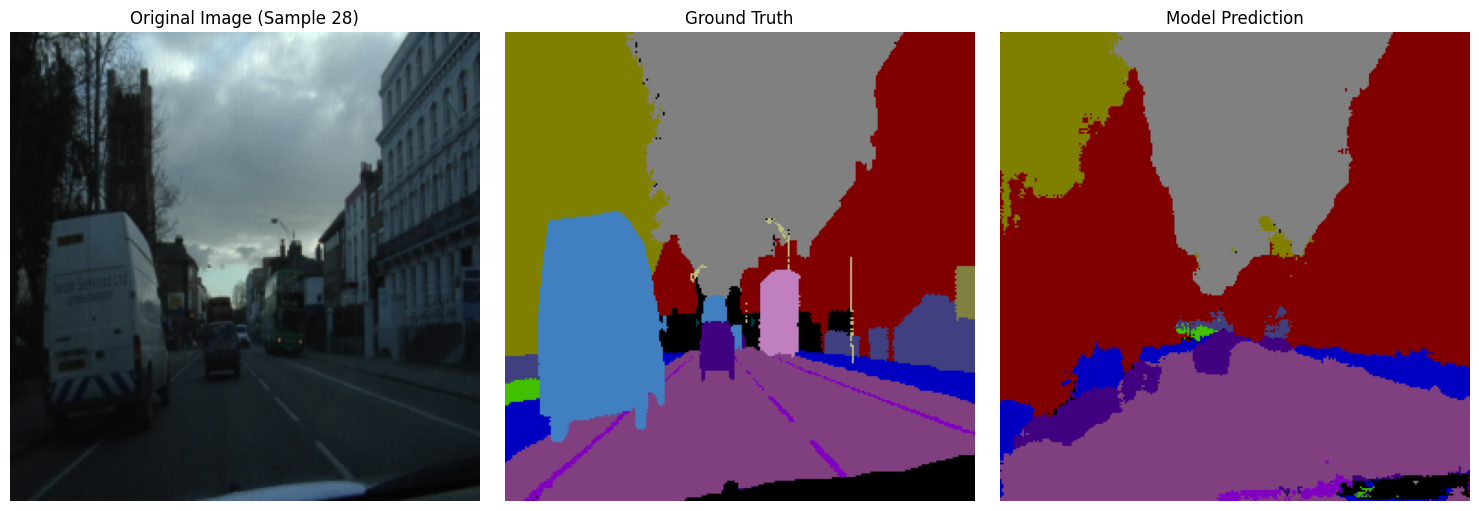

可视化结果已保存到 results_segnet/prediction_sample_6.png


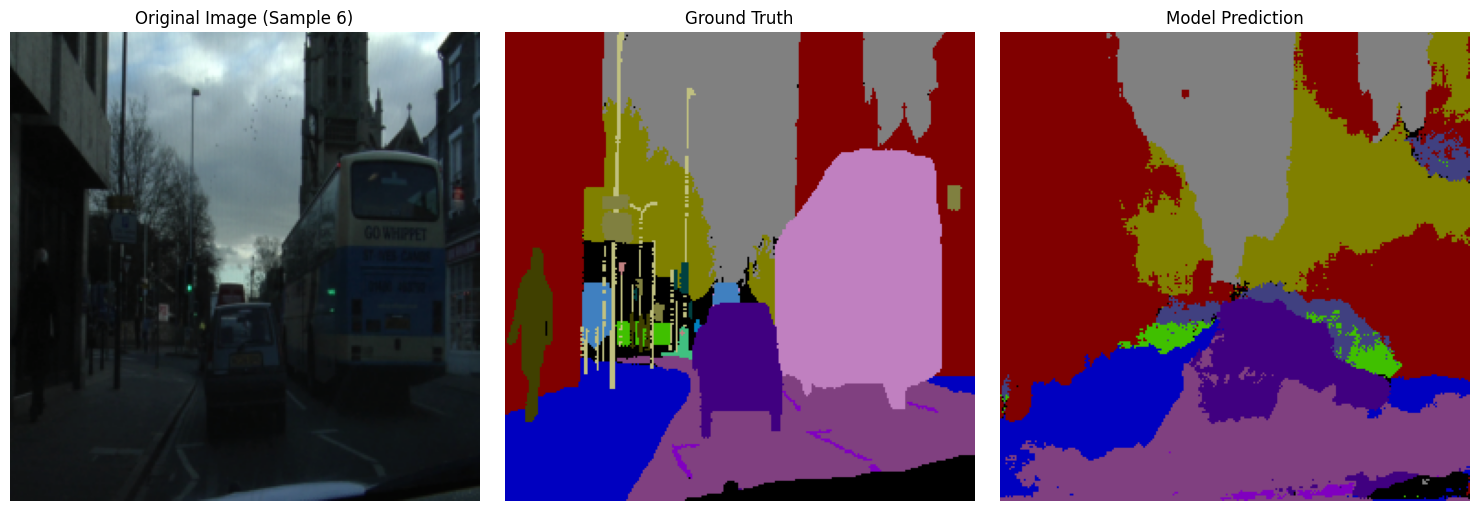

可视化结果已保存到 results_segnet/prediction_sample_189.png


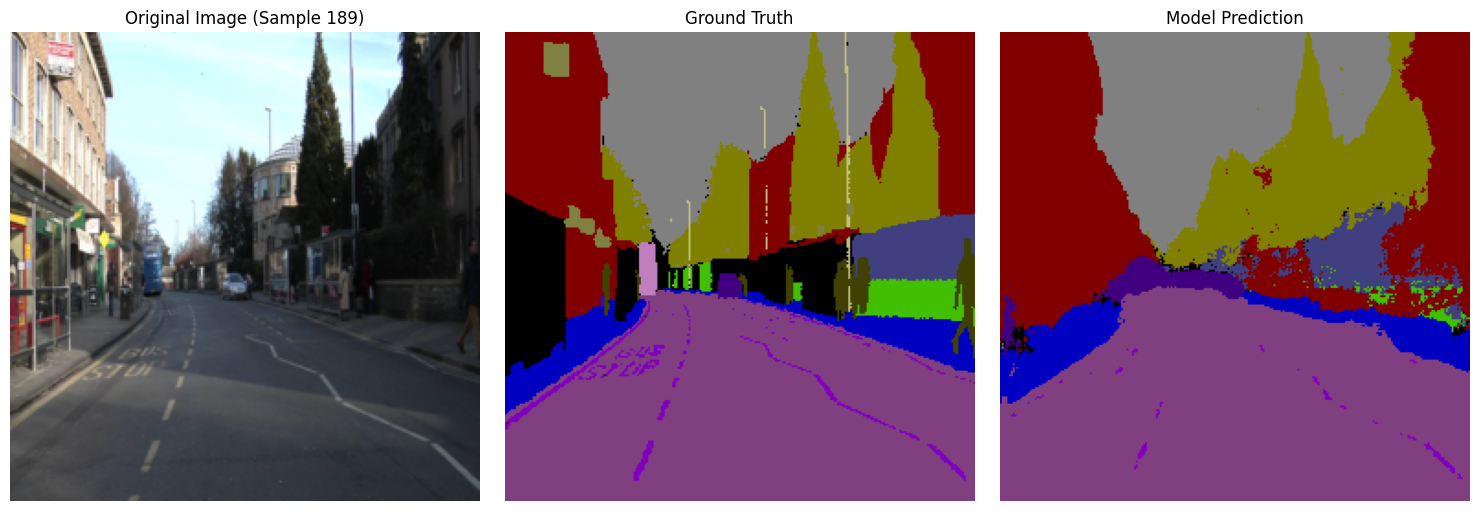

可视化结果已保存到 results_segnet/prediction_sample_70.png


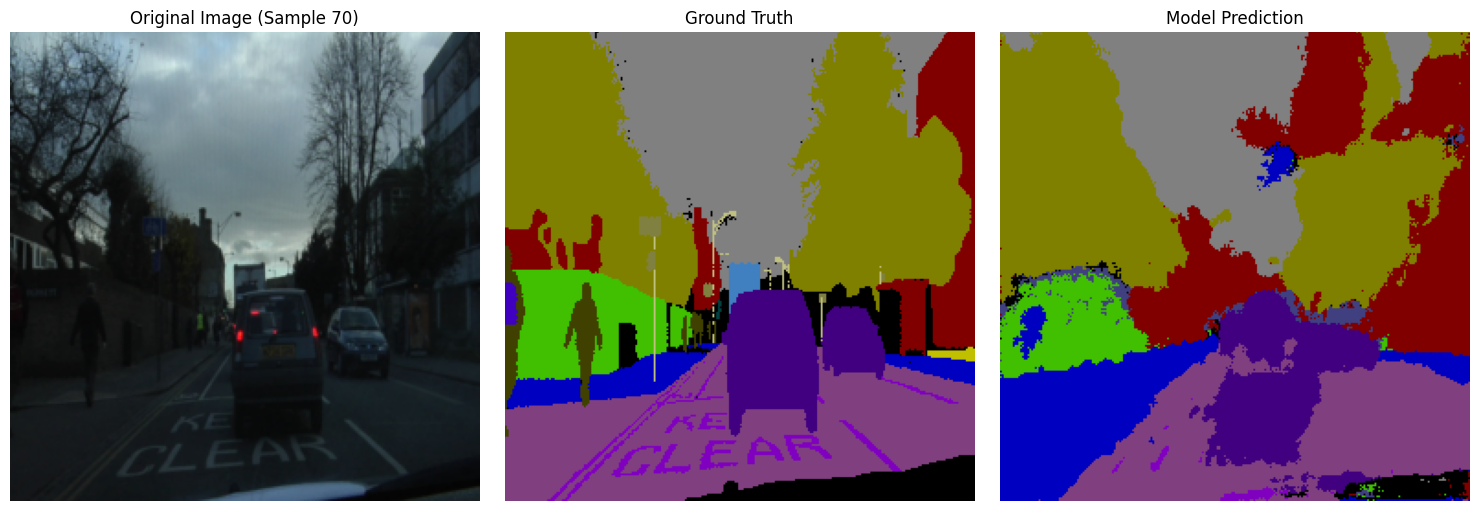

可视化结果已保存到 results_segnet/prediction_sample_62.png


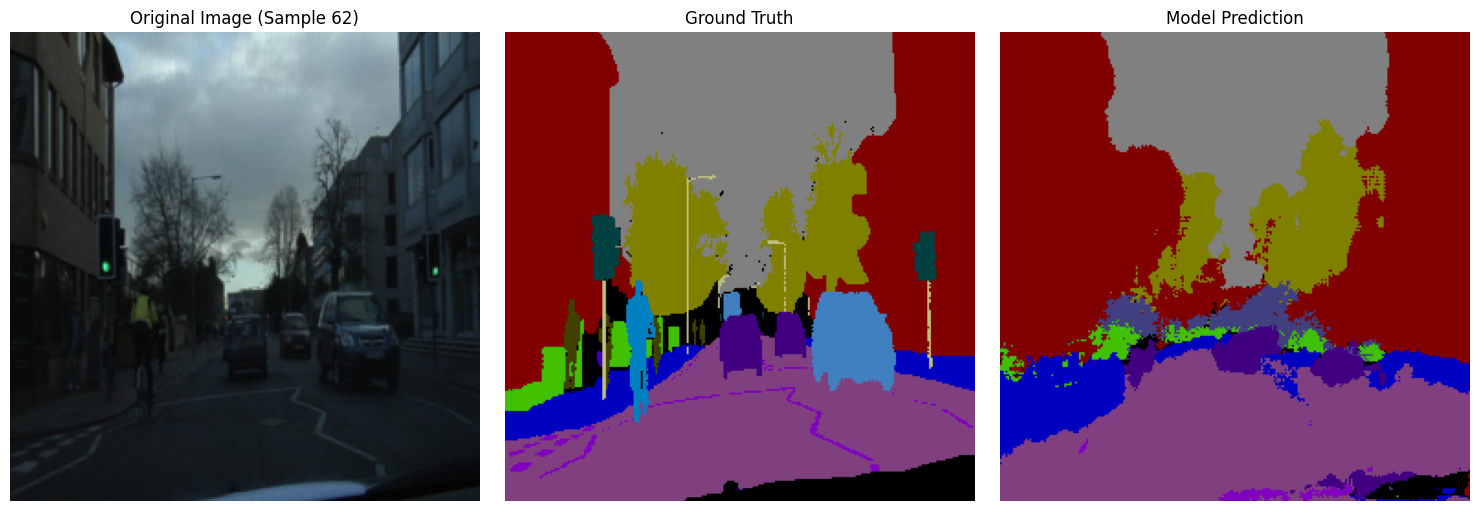

In [63]:
# %% [markdown]
# ## 11. 可视化测试结果
#
# 在测试集上随机选择一些样本，显示原始图像、真实标签和模型预测的分割结果。

# %%
def visualize_predictions(dataset, model, device, num_samples=5, results_save_dir=None):
    model.eval()
    indices = random.sample(range(len(dataset)), min(num_samples, len(dataset)))

    for i, idx in enumerate(indices):
        image_tensor, true_mask_tensor = dataset[idx] # image_tensor is (C,H,W), true_mask_tensor is (H,W)
        
        # 反归一化图像以便显示
        inv_normalize = transforms.Normalize(
            mean=[-0.485/0.229, -0.456/0.224, -0.406/0.225],
            std=[1/0.229, 1/0.224, 1/0.225]
        )
        img_display = inv_normalize(image_tensor.clone()) # clone to avoid modifying original
        img_display = transforms.ToPILImage()(img_display)

        # 获取模型预测
        with torch.no_grad():
            input_tensor = image_tensor.unsqueeze(0).to(device) # (1, C, H, W)
            output_logits = model(input_tensor) # (1, num_classes, H, W)
            pred_mask_tensor = torch.argmax(output_logits.squeeze(0), dim=0) # (H, W)
        
        # 将真实标签和预测掩码转换为 RGB 图像
        true_mask_rgb = mask_to_rgb(true_mask_tensor, idx_to_color)
        pred_mask_rgb = mask_to_rgb(pred_mask_tensor.cpu(), idx_to_color) # pred_mask_tensor might be on GPU

        # 绘图
        fig, ax = plt.subplots(1, 3, figsize=(15, 5))

        ax[0].imshow(img_display)
        ax[0].set_title(f"Original Image (Sample {idx})") # Changed
        ax[0].axis('off')

        ax[1].imshow(true_mask_rgb)
        ax[1].set_title("Ground Truth") # Changed (or "True Mask")
        ax[1].axis('off')

        ax[2].imshow(pred_mask_rgb)
        ax[2].set_title("Model Prediction") # Changed (or "Predicted Mask")
        ax[2].axis('off')
        
        plt.tight_layout()
        if results_save_dir:
            if not os.path.exists(results_save_dir):
                os.makedirs(results_save_dir)
            save_path = os.path.join(results_save_dir, f"prediction_sample_{idx}.png")
            plt.savefig(save_path)
            print(f"可视化结果已保存到 {save_path}")
        plt.show()

print("\n在测试集上可视化一些预测结果:")
visualize_predictions(test_dataset, model, DEVICE, num_samples=5, results_save_dir=RESULTS_DIR)



In [64]:
# %% [markdown]
# ## 12. (可选) 保存测试结果指标
#
# 将测试指标保存到文本文件。

# %%
results_summary_path = os.path.join(RESULTS_DIR, "test_metrics_summary.txt")
with open(results_summary_path, "w") as f:
    f.write("--- 测试集评估结果 ---\n")
    f.write(f"平均测试损失: {avg_test_loss:.4f}\n")
    f.write(f"平均像素准确率: {avg_test_pixel_accuracy:.4f}\n")
    f.write(f"平均交并比 (mIoU): {mean_iou:.4f}\n\n")
    f.write("每个类别的 IoU:\n")
    for i, class_name in enumerate(CLASS_NAMES):
        f.write(f"  {class_name:<20}: {iou_per_class[i]:.4f}\n")

print(f"\n测试结果指标已保存到: {results_summary_path}")

# %% [markdown]
# ---
# # 实验结束
# ---


测试结果指标已保存到: results_segnet/test_metrics_summary.txt
